In [14]:
!pip install langgraph

In [15]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from typing import TypedDict
import time

In [16]:
#define the state
class CrashState(TypedDict):
  input: str
  step1 : str
  step2 : str
  step3 : str

In [17]:
#Define steps means nodes
def step_1(state : CrashState) -> CrashState:
  print("Step 1 executed")
  return {"step1": "done","input":state["input"]}

def step_2(state : CrashState) -> CrashState:
  print("step 2 hanging... now manually interrupt from the notebook toolbar (stop button)")
  time.sleep(30)#delay for 30 sec means simulate long running hang
  return {"step2": "done"}

def step_3(state : CrashState) -> CrashState:
  print("step 3 executed ")
  return { "step3": "done" }




In [18]:
#build the graph
builder = StateGraph(CrashState)

#adding nodes
builder.add_node("step_1",step_1)
builder.add_node("step_2",step_2)
builder.add_node("step_3",step_3)

#adding edges
builder.add_edge(START,"step_1")
builder.add_edge("step_1","step_2")
builder.add_edge("step_2","step_3")
builder.add_edge("step_3",END)

checkpointer = InMemorySaver()

graph = builder.compile(checkpointer=checkpointer)

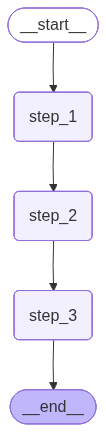

In [19]:
graph

In [20]:
try:
  print("Running graph: please manually interrupt during step 2...")
  graph.invoke({"input":"start"}, config ={"configurable":{"thread_id": 'thread - 1'}})
except KeyboardInterrupt:
  print("Kernel manually interrupted (crash simulated).")




Running graph: please manually interrupt during step 2...
Step 1 executed
step 2 hanging... now manually interrupt from the notebook toolbar (stop button)
Kernel manually interrupted (crash simulated).


In [21]:
graph.get_state({"configurable":{"thread_id": 'thread - 1'}})

StateSnapshot(values={'input': 'start', 'step1': 'done'}, next=('step_2',), config={'configurable': {'thread_id': 'thread - 1', 'checkpoint_ns': '', 'checkpoint_id': '1f09ebdb-d758-6c8b-8001-6dc5294cfc1e'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-01T11:57:01.309021+00:00', parent_config={'configurable': {'thread_id': 'thread - 1', 'checkpoint_ns': '', 'checkpoint_id': '1f09ebdb-d755-610e-8000-7af51121f314'}}, tasks=(PregelTask(id='9b820db8-5b18-a435-4da2-1c45ce9e9d49', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [22]:
list(graph.get_state_history({"configurable":{"thread_id": 'thread - 1'}}))

[StateSnapshot(values={'input': 'start', 'step1': 'done'}, next=('step_2',), config={'configurable': {'thread_id': 'thread - 1', 'checkpoint_ns': '', 'checkpoint_id': '1f09ebdb-d758-6c8b-8001-6dc5294cfc1e'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-01T11:57:01.309021+00:00', parent_config={'configurable': {'thread_id': 'thread - 1', 'checkpoint_ns': '', 'checkpoint_id': '1f09ebdb-d755-610e-8000-7af51121f314'}}, tasks=(PregelTask(id='9b820db8-5b18-a435-4da2-1c45ce9e9d49', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'input': 'start'}, next=('step_1',), config={'configurable': {'thread_id': 'thread - 1', 'checkpoint_ns': '', 'checkpoint_id': '1f09ebdb-d755-610e-8000-7af51121f314'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-01T11:57:01.307498+00:00', parent_config={'configurable': {'thread_id': 'thread - 1', 'checkpoint_ns':

In [23]:
#Re-run to show fault tolerance resume
final_state = graph.invoke(None, config={"configurable":{"thread_id":"thread - 1"}})
print("\n final state : ", final_state)

step 2 hanging... now manually interrupt from the notebook toolbar (stop button)
step 3 executed 

 final state :  {'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}


In [24]:
graph.get_state({"configurable":{"thread_id": 'thread - 1'}})

StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}, next=(), config={'configurable': {'thread_id': 'thread - 1', 'checkpoint_ns': '', 'checkpoint_id': '1f09ebdd-34c1-6bce-8003-b866dfdd900a'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-10-01T11:57:37.947302+00:00', parent_config={'configurable': {'thread_id': 'thread - 1', 'checkpoint_ns': '', 'checkpoint_id': '1f09ebdd-34bd-646c-8002-4a6e0ba16bfb'}}, tasks=(), interrupts=())

In [25]:
list(graph.get_state_history({"configurable":{"thread_id": 'thread - 1'}}))

[StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}, next=(), config={'configurable': {'thread_id': 'thread - 1', 'checkpoint_ns': '', 'checkpoint_id': '1f09ebdd-34c1-6bce-8003-b866dfdd900a'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-10-01T11:57:37.947302+00:00', parent_config={'configurable': {'thread_id': 'thread - 1', 'checkpoint_ns': '', 'checkpoint_id': '1f09ebdd-34bd-646c-8002-4a6e0ba16bfb'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done'}, next=('step_3',), config={'configurable': {'thread_id': 'thread - 1', 'checkpoint_ns': '', 'checkpoint_id': '1f09ebdd-34bd-646c-8002-4a6e0ba16bfb'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-10-01T11:57:37.945472+00:00', parent_config={'configurable': {'thread_id': 'thread - 1', 'checkpoint_ns': '', 'checkpoint_id': '1f09ebdb-d758-6c8b-8001-6dc5294cfc1e'}}, tasks=(PregelTask(id='4b446803-1